# Statistical Modeling of the Gutenberg–Richter Law in Earthquake Data

### *Introduction*: 
According to the Gutenberg-Richter frequency magnitude relation [1], the number of earthquakes N, having a magnitude equal to or larger than M, can be expressed by the equation  


$$log_{10}(N) = a - b*M$$  

where $a$ is a measure of the level of seismicity and $b$ describes the ration between the number of small and large events. The Gutenberg–Richter relation is of significant importance to seismic studies because it is used to
describe both tectonic and induced seismicity, can be applied
in different time scales, and holds true over a large interval of
earthquake magnitudes.  

This project will analyze the Gutenberg–Richter frequency–magnitude relationship using Balkan (1904–2025) earthquake data, with potential comparison to California and Japan. 



#### *Data preprocessing*

In [89]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import missingno as msn
import numpy as np 
import math 

In [90]:
df = pd.read_csv("data/south_central_balkan.csv")
df.sample(3)

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
1799,1991-09-13T12:17:08.830Z,42.710,23.934,10.0,3.3,md,NaN,NaN,NaN,1.4,...,2014-11-07T00:49:15.000Z,"4 km WNW of Mirkovo, Bulgaria",earthquake,NaN,NaN,NaN,NaN,reviewed,us,the
673,2004-09-29T02:19:39.380Z,42.077,19.289,21.4,2.7,ml,12.0,150.3,NaN,NaN,...,2014-11-07T01:23:34.648Z,"12 km E of Stari Bar, Montenegro",earthquake,NaN,NaN,NaN,NaN,reviewed,pdg,pdg
2224,1988-01-22T02:33:36.670Z,43.415,19.945,10.0,3.3,md,NaN,NaN,NaN,1.1,...,2014-11-07T00:41:31.908Z,"24 km E of Prijepolje, Serbia",earthquake,NaN,NaN,NaN,NaN,reviewed,us,ttg


In [91]:
df["magType"].value_counts()

magType
ml      1679
md       847
mb       508
m         58
mw        57
mwr       20
mww       13
mwc       12
ms         2
mblg       1
Name: count, dtype: int64

In [92]:
df["time"] = pd.to_datetime(df["time"]) # Transform time column to hold Pandas DateTime objects 
df.drop_duplicates(inplace=True) # Drop duplicates if any exist 

In [93]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   0
magType               0
nst                2330
gap                2411
dmin               3027
rms                 961
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    3025
depthError         2697
magError           2972
magNst             2734
status                0
locationSource        0
magSource             0
dtype: int64

<Axes: >

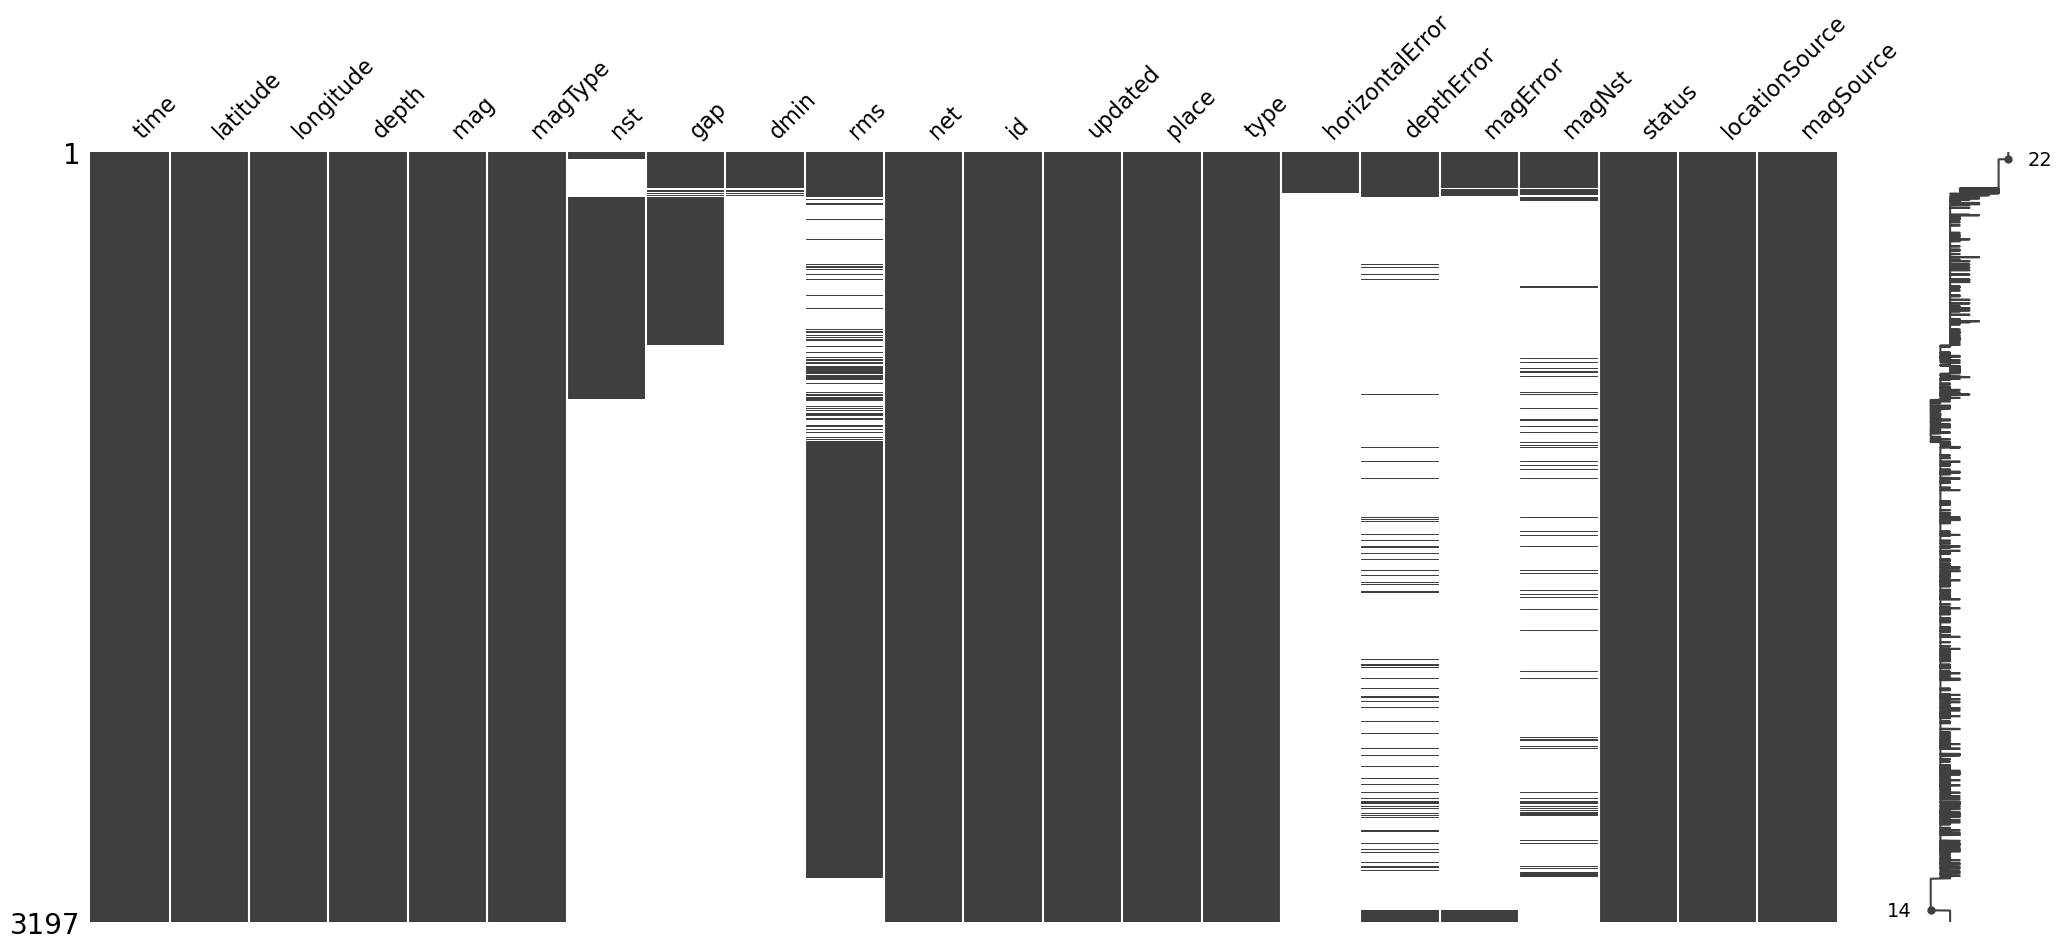

In [94]:
msn.matrix(df)

In [95]:
drop_columns = ["nst", "gap", "dmin", "rms", "horizontalError", "depthError", "magError", "magNst"]
df.drop(columns = drop_columns, inplace = True)

### *EDA and Visualization*

##### *General histogram of earthquake magnitudes*

<Axes: xlabel='mag', ylabel='Count'>

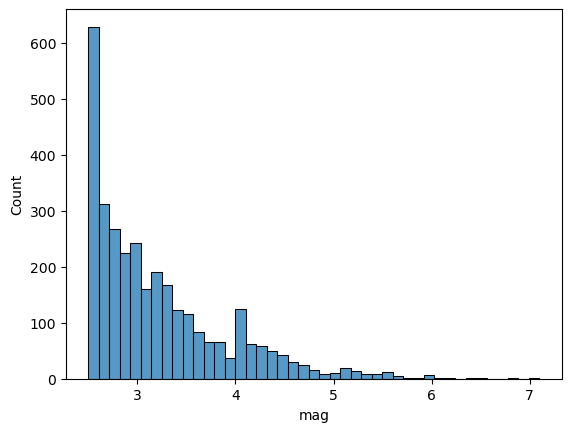

In [96]:
magnitudes = df["mag"] 
sns.histplot(magnitudes) 

##### *Empirical Gutenberg-Richter plot*

In [97]:
bins = [i for i in range(2,8)]  

M_vals = np.linspace(start=2.5, stop=7, num=1000)
M_indices = [i for i in range(len(M_vals))]
counts = [0] * len(M_indices)

j=0 
for M in M_vals:
    for magnitude in magnitudes:
        if magnitude >= M: 
            counts[j] += 1 
    j+=1   


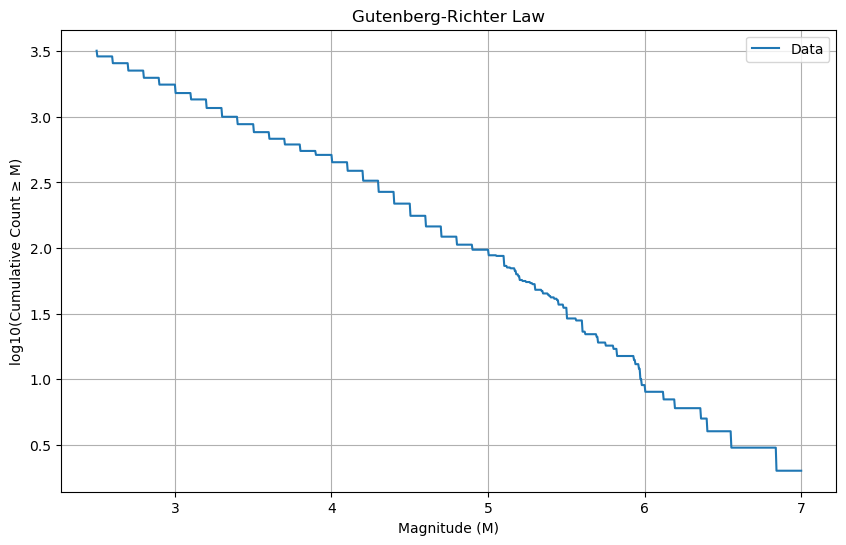

In [98]:
plt.figure(figsize=(10,6))
plt.plot(M_vals, np.log10(counts), label='Data')
plt.xlabel('Magnitude (M)')
plt.ylabel('log10(Cumulative Count ≥ M)')
plt.title('Gutenberg-Richter Law')
plt.grid(True)
plt.legend()
plt.show()

#### *Survival function (CCDF)*

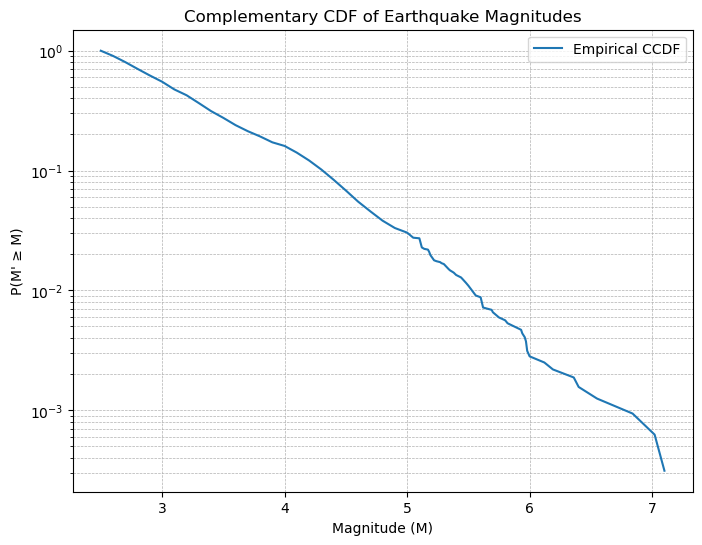

In [99]:
import numpy as np
import matplotlib.pyplot as plt

magnitudes = np.sort(magnitudes)

ccdf = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])

plt.figure(figsize=(8, 6))
plt.plot(magnitudes, ccdf, linestyle="solid", label='Empirical CCDF')
plt.yscale('log')  
plt.xlabel("Magnitude (M)")
plt.ylabel("P(M' ≥ M)")
plt.title("Complementary CDF of Earthquake Magnitudes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### *Statistical Modeling: estimating the b-value in the formula*

##### *Aki's MLE estimator* 
 
 Aki's classic estimator [2] models earthquake magnitudes as a continuous random variable following an exponential distribuiton. The above histogram of the frequencies of earthquakes by magnitudes certainly justifies this assumtion for our data. This approach also assumes a *completenes threshold* - a minimum earthquake magnitude above which we believe all earthquakes are recorded reliably. In this project, we will assume this value is 2.5. Firstly, let us acknowledge that:  

 $\log_{10} N = a - bM $   
 $N = 10^{a - bM} = 10^a \cdot 10^{-bM}$  
 $N \propto 10^{-bM}$

 In order to model earthquake magintudes as exponentially distributed random variables, we will need to convert to an expression in base-$e$, so we have  

 $$10^{-bM} = e^{-bM\cdot \ln(10)}, \text{ and for convenience we will define } \beta = b \cdot \ln(10) $$  

Let $M \geq M_{min}$ be the magnitude. We assume the magnitudes follow: 

$$f(M;\beta) = \beta e^{-\beta(M-M_{min})}$$  


This is a shifted exponential distribution with support $M \in [M_{min}, \inf)$  

Given n independent observations $M_1, M_2, ..., M_n$, the likelihood is:  

$$L(\beta) = \prod_{i=1}^{n} \beta e^{{-\beta(M_i-M_{min})}} = \beta^n e ^{ - \beta \sum_{i=1}^{n}(M_i - M_{min})}$$  

Taking the log of the likelihood function gives us: 

$$\log L(\beta) = n \log \beta - \beta \sum_{i=1}^{n} (M_i - M_{min})$$  

Taking the derivative of the log-likelihood with respect to $\beta$:  

$$\frac{d}{d\beta} \log L(B) = \frac{n}{\beta} - \sum_{i=1}^{n} (M_i - M_{min}) $$  

Setting the derivative equal to zero, and solving for $\hat{\beta}$  

$$\frac{n}{\hat{\beta}} = \sum_{i=1}^{n}$$  
$$\hat{\beta} = \frac{n}{\sum_{i=1}^{n}(M_i - M_{min})}$$  

We can substitute the denominator with $n \cdot (\overline{M} - M_{min})$, and we finally get 


$$\beta = \frac{1}{\overline{M} - M_{min}}$$  

Recall that $\beta = b \cdot \ln (10) $, so our final estimate for $b$ becomes:  

$$\hat{b} = \frac{1}{\ln(10)\cdot(\overline{M} - M_{min})} $$





In [100]:
import numpy as np

M_min = 2.5 
M = magnitudes[magnitudes >= M_min]

mean_mag = np.mean(M)
b_mle = 1 / (np.log(10) * (mean_mag - M_min))
print(f"MLE estimate of b: {b_mle:.4f}")

MLE estimate of b: 0.5970


Comparing the fitted exponential PDF to the histogram of our data.

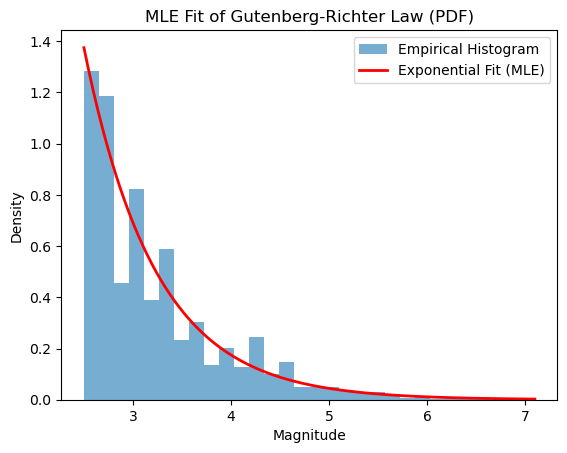

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon

Mmin = 2.5
beta_mle = b_mle * np.log(10)


plt.hist(magnitudes, bins=30, density=True, alpha=0.6, label="Empirical Histogram")

x = np.linspace(Mmin, magnitudes.max(), 200)
pdf = beta_mle * np.exp(-beta_mle * (x - Mmin))
plt.plot(x, pdf, 'r-', lw=2, label=f"Exponential Fit (MLE)")

plt.xlabel("Magnitude")
plt.ylabel("Density")
plt.title("MLE Fit of Gutenberg-Richter Law (PDF)")
plt.legend()
plt.show()


Comparing the CCDF of our data vs with our fitted b value.

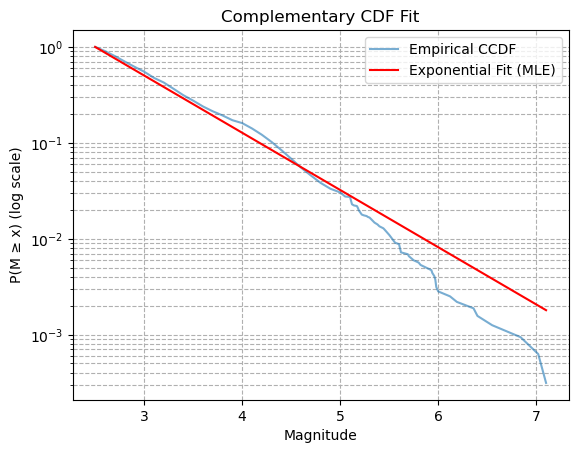

In [102]:
sorted_mags = np.sort(magnitudes)
ccdf_empirical = np.array([np.sum(magnitudes >= m) / len(magnitudes) for m in magnitudes])
ccdf_theoretical = np.exp(-beta_mle * (sorted_mags - Mmin))

plt.plot(sorted_mags, ccdf_empirical, label="Empirical CCDF",  linestyle='solid', alpha=0.6)
plt.plot(sorted_mags, ccdf_theoretical, label="Exponential Fit (MLE)", color='r')

plt.yscale('log')
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x) (log scale)")
plt.title("Complementary CDF Fit")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


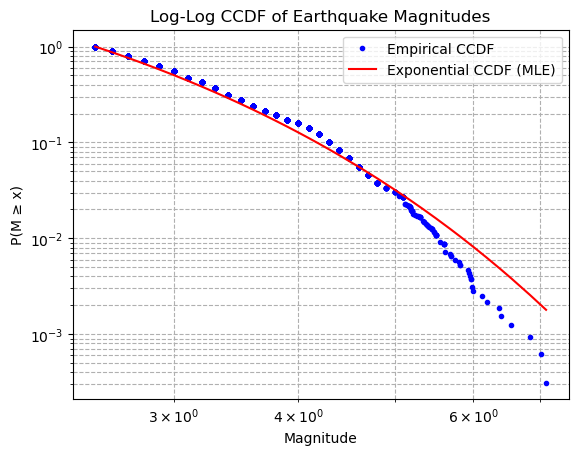

In [103]:
plt.loglog(sorted_mags, ccdf_empirical, 'b.', label="Empirical CCDF")
plt.loglog(sorted_mags, ccdf_theoretical, 'r-', label="Exponential CCDF (MLE)")
plt.xlabel("Magnitude")
plt.ylabel("P(M ≥ x)")
plt.title("Log-Log CCDF of Earthquake Magnitudes")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

While the exponential model provides a theoretically justified fit (per the Gutenberg–Richter law), the Kolmogorov–Smirnov test revealed significant deviation between the observed and predicted distributions (K–S statistic = 0.0951, p-value ≈ 0), suggesting that the model may not fully capture the statistical properties of the dataset.

In [ ]:
from scipy.stats import kstest

D, p_value = kstest(magnitudes, lambda x: expon.cdf(x, loc=Mmin, scale=1/beta_mle))
print(f"K-S Statistic: {D:.4f}, p-value: {p_value:.4f}")

K-S Statistic: 0.0951, p-value: 0.0000


##### *Bayesial approach* 
Yaghmaei-Sabegh et al. [3] propose a Bayesian approach to estimating the b-parameter. We will retain our exponential assumption when deriving the likelihood function for the data, but we will introduce a Gamma prior for our $\beta$ parameter. Note: due to the ambiguity of the $\beta$ parameter analyised in the context of the Gutenberg-Richter law and the one used as a parameter in the gamma distribution in most literature, this text will use unconventional notation - denoting $\alpha$ and $\beta$ of the gamma distribution as $k$ and $\lambda$, respectivelly.  

First, for our beta prior we have  


$$p(\beta) = \frac{\lambda^k}{\Gamma(k)} \beta^{k-1} e^{-\lambda \beta}$$  

Using the same likelihood function as before, we can derive the posterior as follows: 



$$
p(\beta \mid \bold{m}) \propto p(\bold{m} \mid \beta) p(\beta)$$     
$$\propto \beta^n e^{-\beta S} \cdot \beta^{k-1} e^{-\lambda \beta}$$ 
$$\propto \beta^{n + k - 1} e^{-\beta (S + \lambda)},$$ 



where $\bold{m}$ is our data and  $S = \sum_{i=1}^{n}(M_{i} - M_{min} )$ 

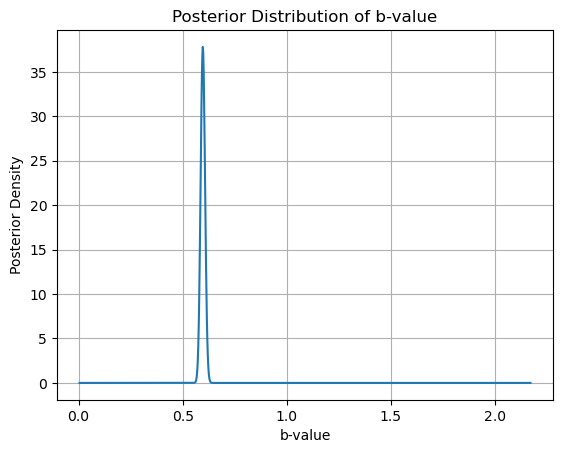

In [105]:
import numpy as np
from scipy.stats import gamma
import matplotlib.pyplot as plt

# Sample data: replace with your earthquake 
M_min = np.min(magnitudes)

# Transform data
data = magnitudes -M_min
n = len(data)
sum_data = np.sum(data)

# Prior parameters
alpha_prior = 1.0  # Non-informative prior
theta_prior = 1.0

# Posterior parameters
alpha_post = alpha_prior + n
theta_post = 1 / (1 / theta_prior + sum_data)

# Posterior distribution for beta
beta_vals = np.linspace(0.01, 5, 1000)
posterior_beta = gamma.pdf(beta_vals, a=alpha_post, scale=theta_post)

# Transform to b-values
b_vals = beta_vals / np.log(10)
posterior_b = posterior_beta * np.log(10)  # Adjust for change of variables

# Plotting
plt.plot(b_vals, posterior_b)
plt.xlabel('b-value')
plt.ylabel('Posterior Density')
plt.title('Posterior Distribution of b-value')
plt.grid(True)
plt.show()


0.4609784584967585

#### *References*
[1] - Gutenberg, B., and C. F. Richter (1944). Frequency of earthquakes in
California, Bull. Seismol. Soc. Am. 34  
[2] - Aki, K. (1965). Maximum likelihood estimate of b in the formula log N =
a - bM and its confidence limits, Bull. Earthq. Res. Inst. Tokyo Univ.
43
[3] - Yaghmaei-Sabegh, S., Ostadi-Asl, G. Bayesian estimation of b-value in Gutenberg–Richter relationship: a sample size reduction approach. Nat Hazards 110, 1783–1797 (2022). https://doi.org/10.1007/s11069-021-05012-0